# Generación de Predicciones con Regresión Lineal
Este notebook implementa una regresión lineal para predecir valores en un conjunto de datos simulados.

## 1. Importación de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



## 2. Extracción y limpieza de datos

<span style="color:white; font-weight:bold">2.1 Extracción</span>

Los datos se generaron directamente de la base de datos MSSQL con las ventas reales de la empresa HBS-Delli, del 2020 a la fecha (diciembre 2024).

In [2]:
df = pd.read_excel("../data/Ventas_CapstoneProject_Agrupado.xlsx", sheet_name="Por_Semana")

**2.2 funciones**

In [3]:
def eliminar_datos_atipicos(input_df):
    
    # Calcular Q1 (percentil 25) y Q3 (percentil 75)
    Q1 = input_df['cantidad'].quantile(0.25)
    Q3 = input_df['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores no atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame eliminando valores atípicos
    df_sin_picos = input_df[(input_df['cantidad'] >= lower_bound) & (input_df['cantidad'] <= upper_bound)]

    #Comentar si se quieren utilizar datos atipicos
    df = df_sin_picos

    return df_sin_picos

<span style="color:white; font-weight:bold">2.2 Limpieza</span>

La mayor parte de la limpieza de datos se realizaron directamente en la base de datos MSSQL, sin embargo se utilizo pandas para realizar una validación de la información y preparar el dataset para su analisis.

In [4]:
#validar nulos
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print("Se eliminaron las filas con valores nulos.")
else:
    print("No se encontraron valores nulos en el DataFrame.")

# Preparando información de la venta
df = df.rename(columns={'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Semana_Anio": "semana_anio"
                        , "Anio": "anio"
                        , "Fecha_Inicio_Semana": "fecha_inicio_semana"
                        })

# Preparando informacion del artículo
df['numero_articulo'] = pd.to_numeric(
                                    df['Articulo'].str.extract(r'(\d+)')[0]     # Extraer solo números
                                    ,errors='coerce'                            # Convertir valores inválidos a NaN
                                    ).fillna(0).astype(int)                     # Reemplazar NaN por 0 y convertir a entero
df = df.rename(columns={"Articulo": "articulo"
                        ,'Desc_Articulo': 'desc_articulo'
                        , 'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Mov": "mov"
                        , "MovId": "movId"
                        , "Lote": "lote"
                        })

# Preparando información del cliente
df = df.rename(columns={'Numero_Cliente': 'numero_cliente'
                        , 'Nombre_Cliente': 'nombre_cliente'
                        , "Rama": "rama_cliente"
                        , "Tipo" : "tipo_cliente"
                        , "Linea": "linea"
                        , "Modulo": "modulo"
                        })
df['numero_cliente'] = df['numero_cliente'].fillna('Desconocido')

# Preparando información de las cantidad
df = df.rename(columns={"Cantidad": "cantidad"
                        , "Lote": "lote"
                        , "UM": "unidad_medida"
                        , "Precio": "precio"
                        , "SubTotal": "subTotal"
                        , "DescuentoLineal": "descuento_lineal"
                        , "IVA": "iva"
                        , "IEPS": "ieps"
                        , "ImporteTotal": "importe_total"
                        , "Costo_Unitario": "costo_unitario"
                        , "Costo_Total": "costo_total"
                          })
# validando columna de tipo fecha
if (df["fecha_emision"].dtypes=="object"):
    df["fecha_emision"] = pd.to_datetime(df["fecha_emision"], errors='coerce', format='%d/%m/%Y')
    print(f"La columna '{"fecha_emision"}' ha sido convertida a datetime.")
else:
    print(f"La columna '{"fecha_emision"}' ya es de tipo datetime, no es necesario convertir.")

# Eliminando información no requerida para el analisis
df = df.drop(columns=["IEPS_Cuota", "Numero_Orden"])

df = eliminar_datos_atipicos(df)

No se encontraron valores nulos en el DataFrame.
La columna 'fecha_emision' ya es de tipo datetime, no es necesario convertir.


<h2>División de datos</h2>

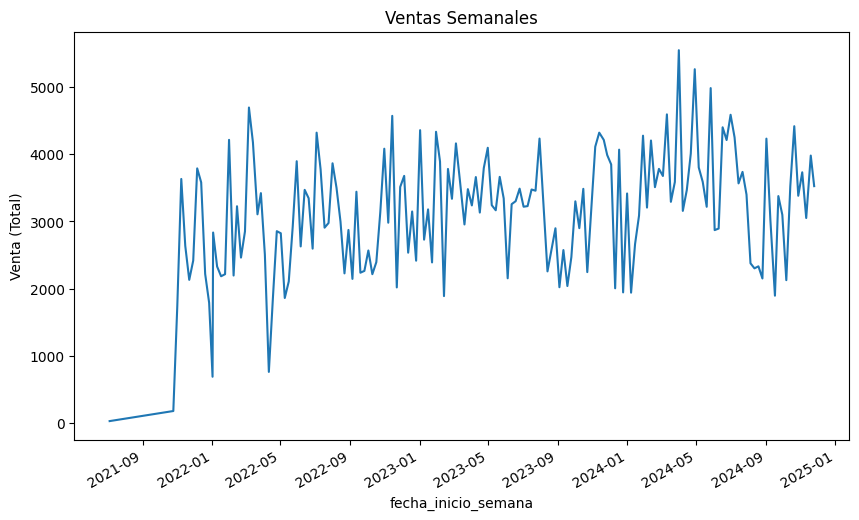

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\

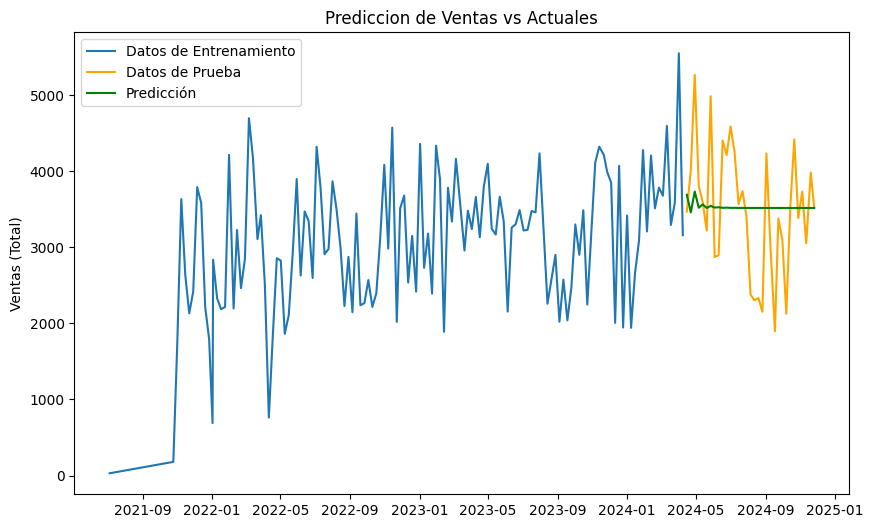

Mean Absolute Error (MAE): 644.82


In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Metrica de cantidad de ventas (suma) agrupado por fecha semanal
df_filtro = df[df["numero_articulo"] == 2429].copy()
df_sales = df_filtro.groupby('fecha_inicio_semana')['cantidad'].sum()

# Indice ordenado cronologicamente
df_sales = df_sales.sort_index()

# Gráfica de series de tiempo
plt.figure(figsize=(10, 6))
df_sales.plot(title="Ventas Semanales", ylabel="Venta (Total)")
plt.show()

# Datos de entrenamiento
train_size = int(len(df_sales) * 0.8)
train, test = df_sales[:train_size], df_sales[train_size:]

# Entrenando el modelo ARIMA
model = ARIMA(train, order=(5, 1, 1))  # Adjust (p, d, q) for better performance
model_fit = model.fit()

# Predicciones de prueba
forecast = model_fit.forecast(steps=len(test))
forecast_index = test.index

# Graficando prediccion vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label="Datos de Entrenamiento")
plt.plot(test.index, test, label="Datos de Prueba", color="orange")
plt.plot(forecast_index, forecast, label="Predicción", color="green")
plt.legend()
plt.title("Prediccion de Ventas vs Actuales")
plt.ylabel("Ventas (Total)")
plt.show()

# Evaludando el modelo
mae = mean_absolute_error(test, forecast)
print(f"Mean Absolute Error (MAE): {mae:.2f}")


**Fine-Tunning ARIMA**

C:\Users\j.carrillo\AppData\Local\Temp\ipykernel_17736\2140390036.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_monthly = df_sales.resample('M').sum()


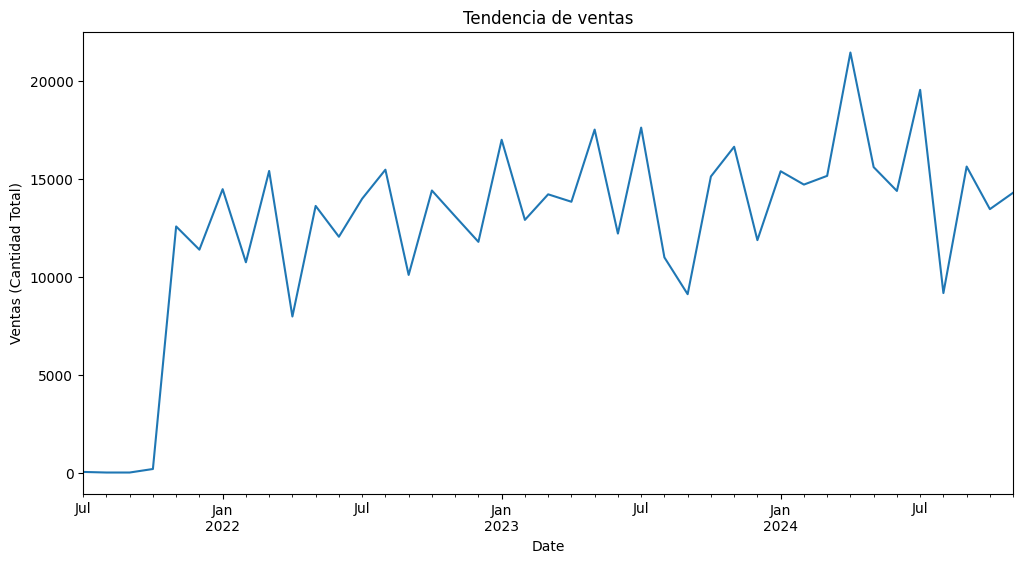

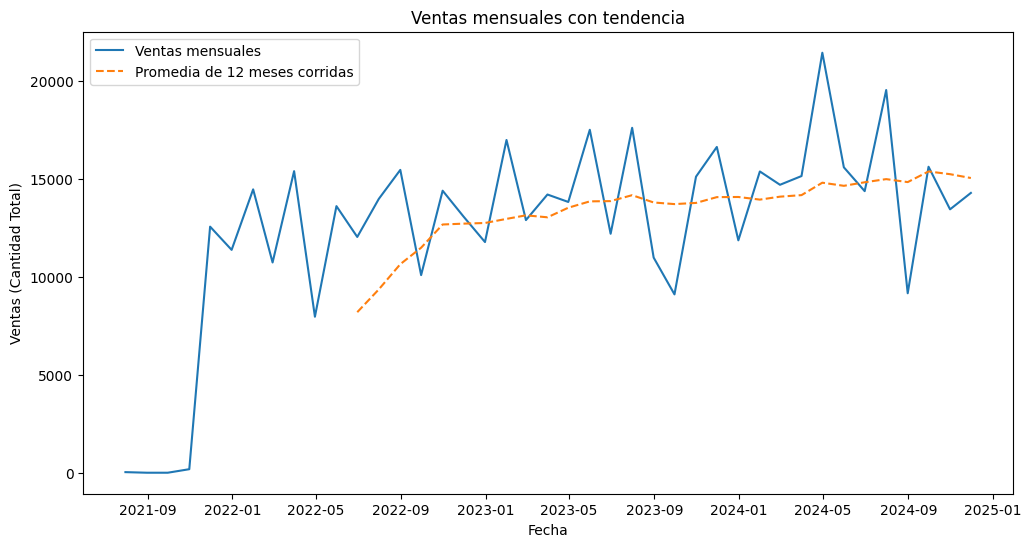

In [11]:
sales_monthly = df_sales.resample('M').sum()

# Graficando tendencia de ventas
plt.figure(figsize=(12, 6))
sales_monthly.plot(title="Tendencia de ventas", ylabel="Ventas (Cantidad Total)", xlabel="Date")
plt.show()

rolling_avg = sales_monthly.rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(sales_monthly, label="Ventas mensuales")
plt.plot(rolling_avg, label="Promedia de 12 meses corridas", linestyle='--')
plt.title("Ventas mensuales con tendencia")
plt.ylabel("Ventas (Cantidad Total)")
plt.xlabel("Fecha")
plt.legend()
plt.show()


**Descomposicion**

<Figure size 1800x1800 with 0 Axes>

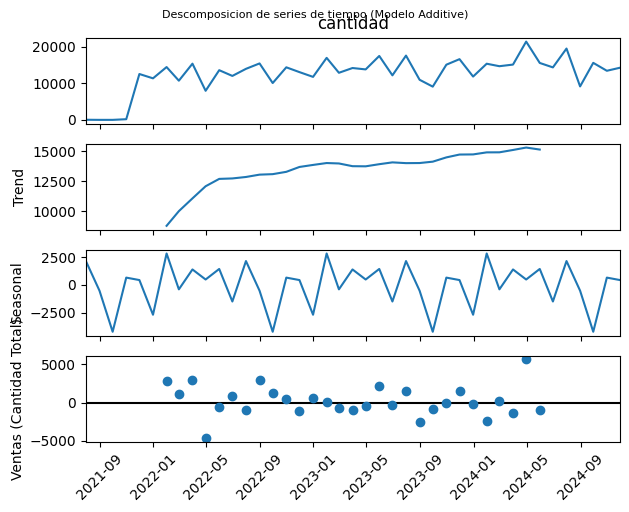

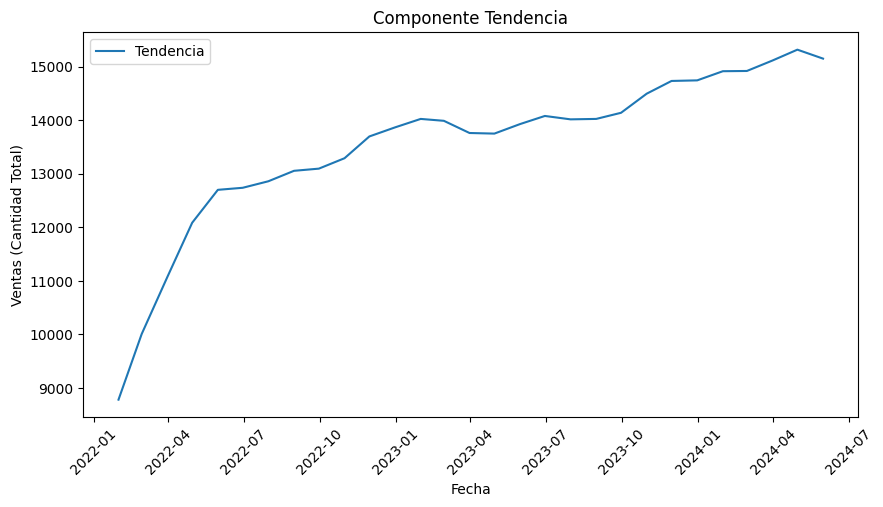

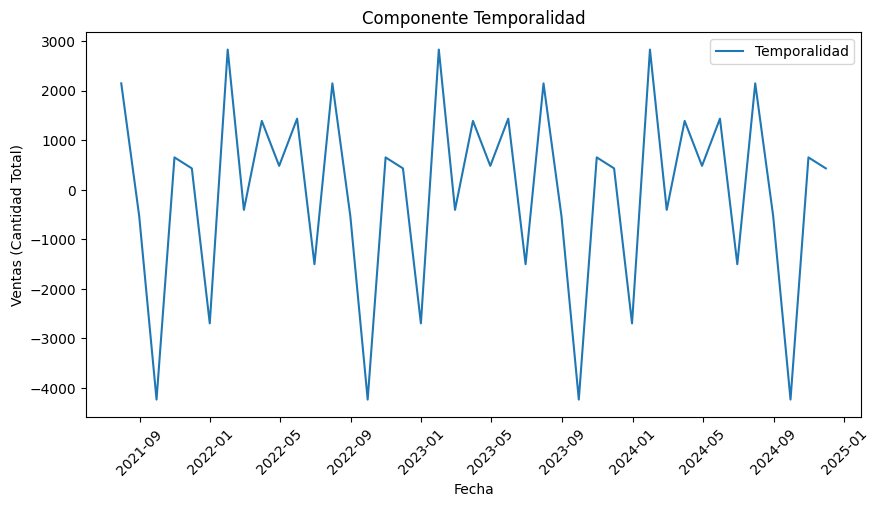

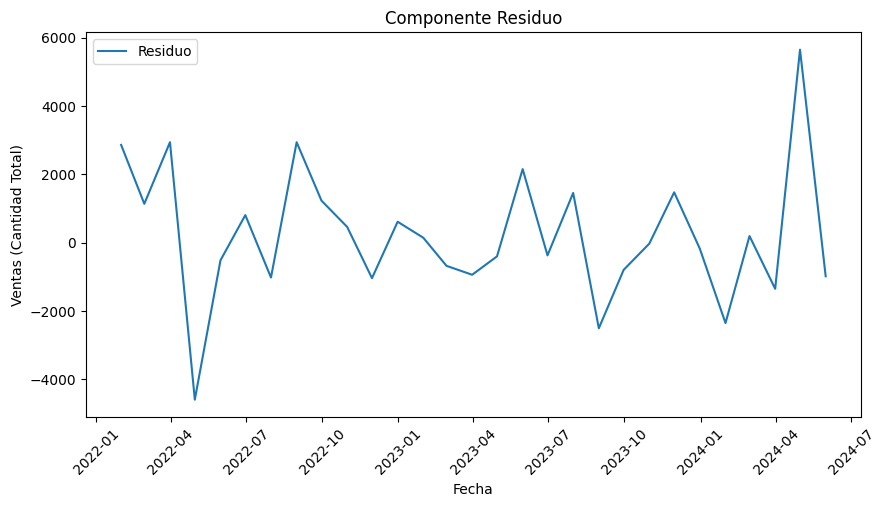

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponiendo las series de tiempo en: Tendencia, Temporalidad, Componente residual
decomposition = seasonal_decompose(sales_monthly, model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(18, 18))
decomposition.plot()
plt.suptitle("Descomposicion de series de tiempo (Modelo Additive)", fontsize=8)
plt.ylabel("Ventas (Cantidad Total)")
plt.xticks(rotation=45)
plt.show()

# Analisando componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))
plt.plot(trend, label="Tendencia")
plt.title("Componente Tendencia")
plt.ylabel("Ventas (Cantidad Total)")
plt.xlabel("Fecha")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(seasonal, label="Temporalidad")
plt.title("Componente Temporalidad")
plt.ylabel("Ventas (Cantidad Total)")
plt.xlabel("Fecha")
plt.legend()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(residual, label="Residuo")
plt.title("Componente Residuo")
plt.ylabel("Ventas (Cantidad Total)")
plt.xlabel("Fecha")
plt.legend()
plt.xticks(rotation=45)
plt.show()


**Prediccion utilizando Tendencia y temporalidad.**

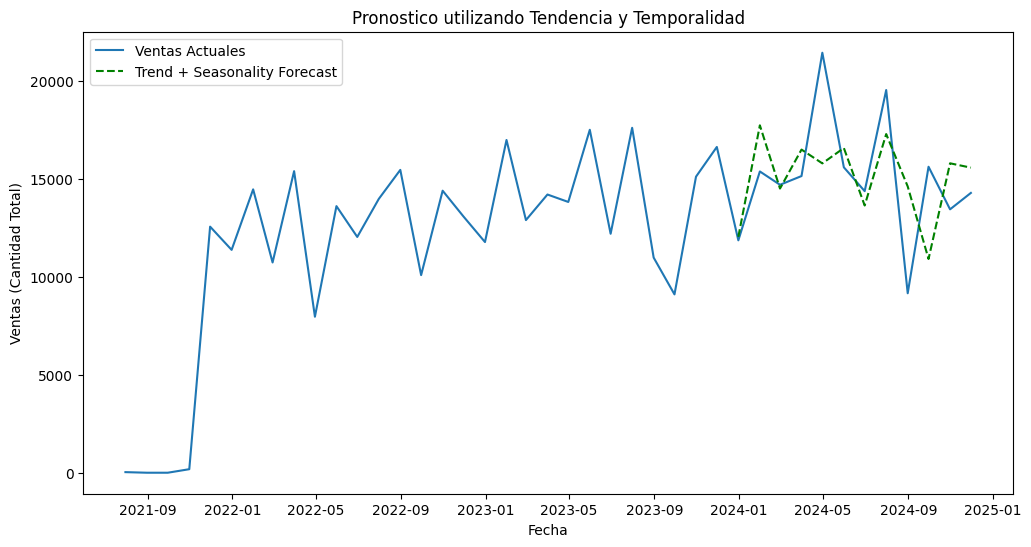

Mean Absolute Error (MAE) of the enhanced forecast: 2292.13


In [28]:
# Predicción del componente Tendencia
trend_forecast = trend.interpolate(method='linear').iloc[-12:]

# Prediccion del compoennte Temporalidad
seasonal_forecast = seasonal.iloc[-12:]

# Prediccion combinada Tendencia y Temporalidad
forecast_combined = trend_forecast + seasonal_forecast

# Grafica de prediccion combinada
plt.figure(figsize=(12, 6))
plt.plot(sales_monthly, label="Ventas Actuales")
plt.plot(forecast_combined.index, forecast_combined, label="Trend + Seasonality Forecast", color="green", linestyle='--')
plt.title("Pronostico utilizando Tendencia y Temporalidad")
plt.ylabel("Ventas (Cantidad Total)")
plt.xlabel("Fecha")
plt.legend()
plt.show()

mae_enhanced = mean_absolute_error(sales_monthly.iloc[-12:], forecast_combined)
print(f"Mean Absolute Error (MAE) of the enhanced forecast: {mae_enhanced:.2f}")
